In [1]:
# Import general libraries
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# Load the image data: loaded as a 2D numpy array
# dtype='>f4': 32 bit little-endian single-precision float
from astropy.io import fits
from auto_stretch import apply_stretch

# Load the image data
img_path = 'dataset/hst_skycell-p0047x09y19_acs_wfc_f658n_all_drc.fits'
raw_img = fits.getdata(img_path)

# Stretch the image for better visualization
stretched_img = apply_stretch(raw_img)


In [3]:
# # comment/uncomment for interactive visualization
# %matplotlib tk

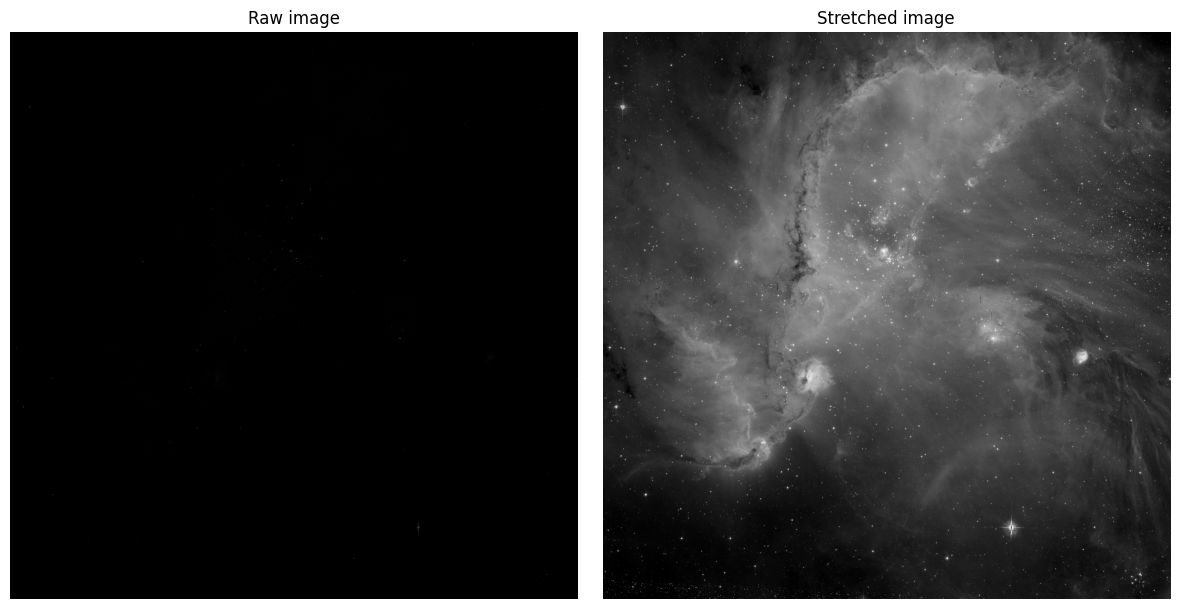

In [4]:
# VISUALIZATION
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot raw image
axes[0].imshow(raw_img, cmap='gray')
axes[0].set_title('Raw image')
axes[0].axis('off')

# Plot stretched image
axes[1].imshow(stretched_img, cmap='gray')
axes[1].set_title('Stretched image')
axes[1].axis('off')

plt.tight_layout()
plt.show()

In [5]:
# COMPUTE A CONVOLUTION USING A GAUSSIAN KERNEL
from math import ceil

# Define Gaussian Kernel
# FWHM: full width at half maximum, a measure to estimate the size of stars
# compute the kernel for small/medium size stars, as bigger ones are fewer and can be treated separately
FHWM = 7 # pixels
sigma = ceil(FHWM / 2.355) # std deviation
kernel_size = (6*sigma) + 1 # rule for kernel size

print(f'Sigma: {sigma}')
print(f'Kernel size: {kernel_size}x{kernel_size}')

gauss_img = cv2.GaussianBlur(stretched_img, (kernel_size, kernel_size), sigma)

Sigma: 3
Kernel size: 19x19


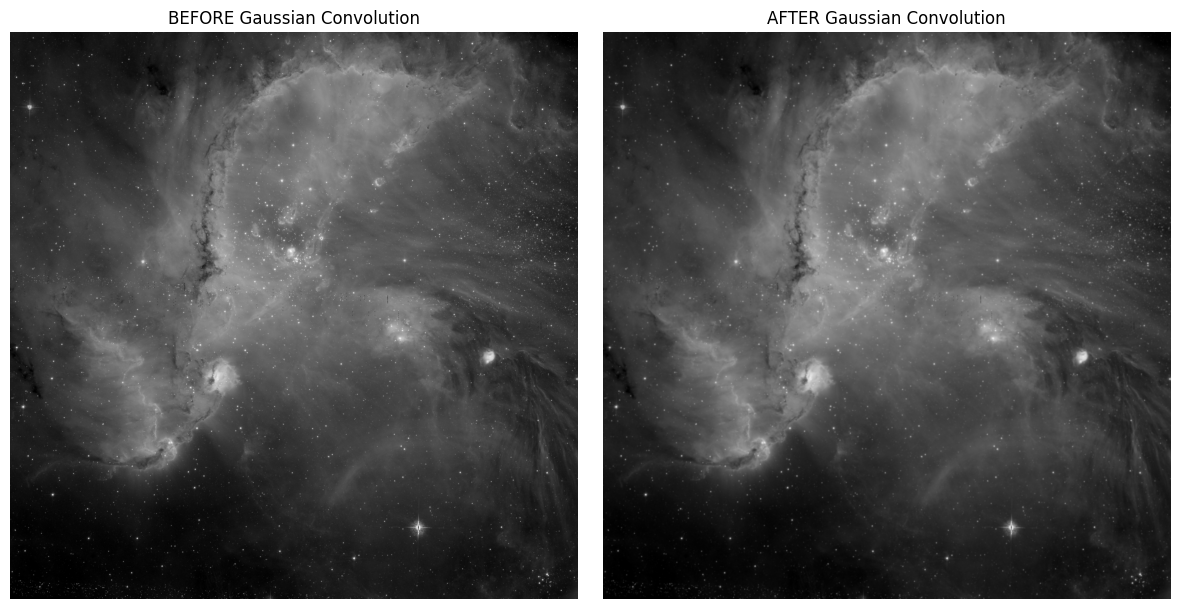

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot image BEFORE convolution against Gaussian kernel
axes[0].imshow(stretched_img, cmap='gray')
axes[0].set_title('BEFORE Gaussian Convolution')
axes[0].axis('off')

# Plot image AFTER convolution against Gaussian kernel
axes[1].imshow(gauss_img, cmap='gray')
axes[1].set_title('AFTER Gaussian Convolution')
axes[1].axis('off')

plt.tight_layout()
plt.show()

In [7]:
# Sobel gradient
sobel_x = cv2.Sobel(gauss_img, cv2.CV_32F, 1, 0, ksize=3)
sobel_y = cv2.Sobel(gauss_img, cv2.CV_32F, 0, 1, ksize=3)
grad_mag = cv2.magnitude(sobel_x, sobel_y)

grad_mag

# # Display the gradient magnitude
# plt.figure(figsize=(12,6))
# plt.imshow(grad_mag, cmap='gray')
# plt.title('Sobel Gradient Magnitude')
# plt.axis('off')
# plt.show()

array([[0.0000000e+00, 3.3183694e-03, 6.2715560e-03, ..., 6.2422812e-05,
        1.6314079e-05, 0.0000000e+00],
       [9.8881125e-04, 3.4628066e-03, 6.3605672e-03, ..., 1.9453654e-04,
        1.8384906e-04, 1.8411214e-04],
       [1.8582343e-03, 3.7973148e-03, 6.5712021e-03, ..., 3.3479949e-04,
        3.2811009e-04, 3.2969823e-04],
       ...,
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 5.0428137e-03,
        3.2150566e-03, 2.4954081e-03],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 5.5660275e-03,
        2.8903766e-03, 1.2896657e-03],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 5.7635903e-03,
        2.7744174e-03, 0.0000000e+00]], shape=(4940, 4940), dtype=float32)

In [8]:
# Apply thresholding to the gradient magnitude
# Simple binary thresholding
T = 16e-2 # threshold
print(T)
max_intensity = 1
_, binary_mask = cv2.threshold(grad_mag, T, max_intensity, cv2.THRESH_BINARY)
binary_mask

0.16


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(4940, 4940), dtype=float32)

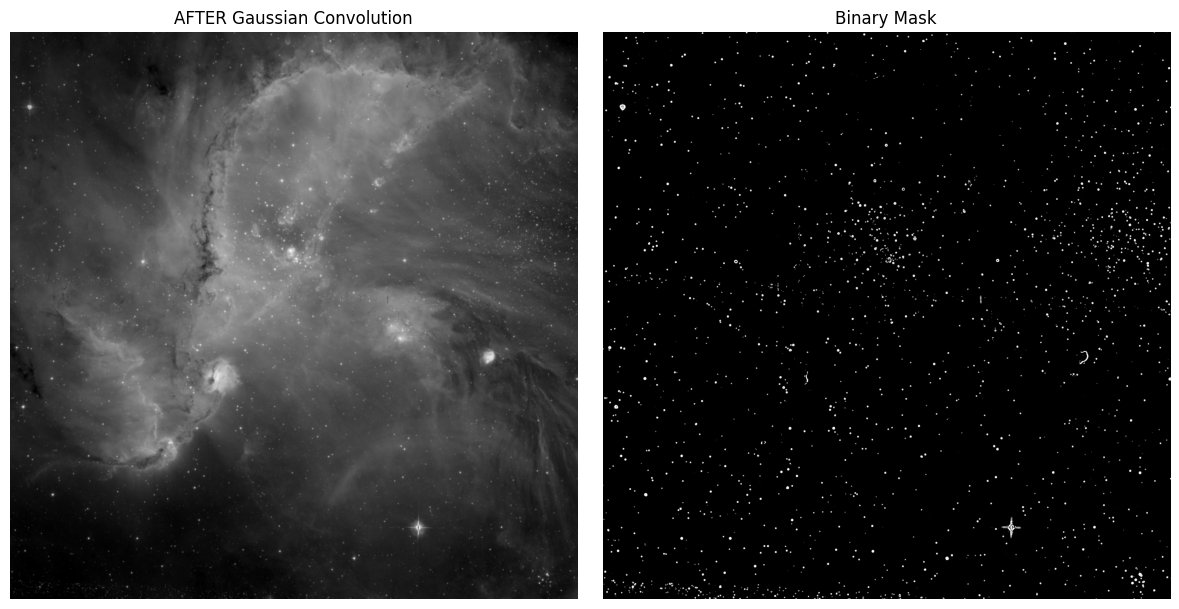

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot the Gaussian convolved image
axes[0].imshow(gauss_img, cmap='gray')
axes[0].set_title('AFTER Gaussian Convolution')
axes[0].axis('off')

# Plot the binary mask
axes[1].imshow(binary_mask, cmap='gray')
axes[1].set_title('Binary Mask')
axes[1].axis('off')

plt.tight_layout()
plt.show()

In [10]:
# Using morphological closing to close small gaps in edges before filling
def morph_close_and_fill(mask):
    # Convert binary mask to uint8 (0 - 255)
    mask_uint8 = (mask * 255).astype(np.uint8)
    # Create a kernel for morphological operations
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    
    # Close small gaps in the edges
    closed_edges = cv2.morphologyEx(mask_uint8, cv2.MORPH_CLOSE, kernel)
    
    # Find contours and fill
    contours, _ = cv2.findContours(closed_edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    final_mask_uint8 = np.zeros_like(mask_uint8)
    cv2.drawContours(final_mask_uint8, contours, -1, 255, -1)
    
    # Back to float32 0.0/1.0
    final_mask = (final_mask_uint8.astype(np.float32) / 255.0)

    return final_mask, final_mask_uint8

final_mask, final_mask_uint8 = morph_close_and_fill(binary_mask)
final_mask.max(), final_mask_uint8.max()

(np.float32(1.0), np.uint8(255))

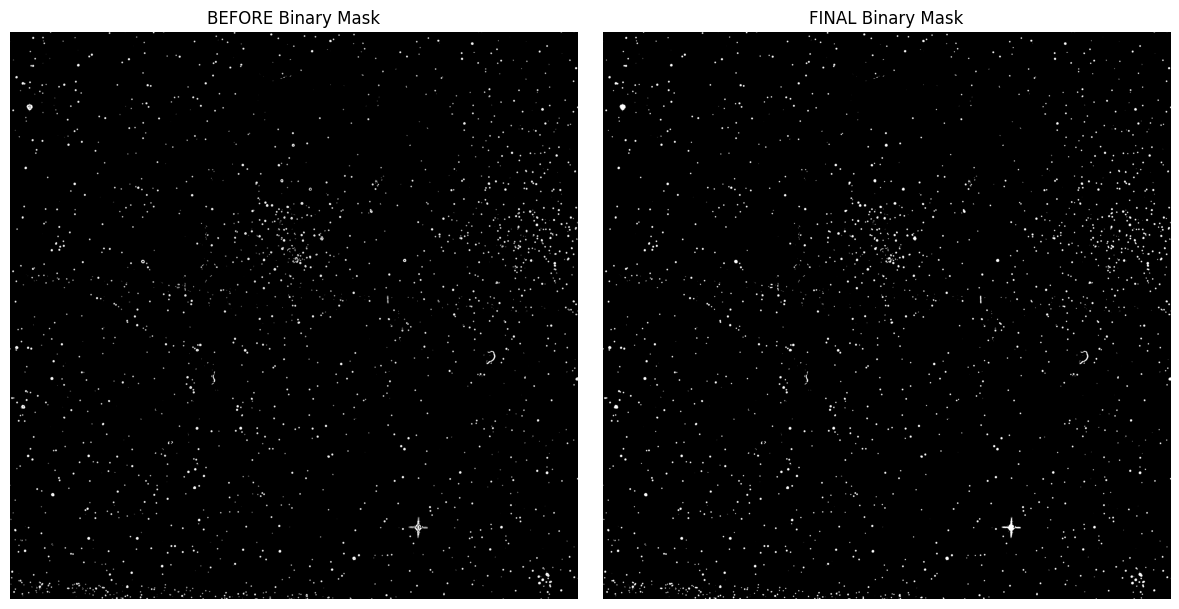

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot BEFORE binary mask
axes[0].imshow(binary_mask, cmap='gray')
axes[0].set_title('BEFORE Binary Mask')
axes[0].axis('off')

# Plot FINAL binary mask
axes[1].imshow(final_mask, cmap='gray')
axes[1].set_title('FINAL Binary Mask')
axes[1].axis('off')

plt.tight_layout()
plt.show()

In [12]:
# def float32_to_uint8(float_img):
#     """
#     Convert a float32 image to uint8 format.
    
#     Parameters:
#     - float_img: np.float32 array, input image
    
#     Returns:
#     - np.uint8 array, output image with values in range 0-255
#     """
#     # Check the current range of the image
#     min_val = float_img.min()
#     max_val = float_img.max()
    
#     # Method 1: Simple scaling (for images already in 0-1 range)
#     if 0 <= min_val and max_val <= 1:
#         uint8_img = (float_img * 255).astype(np.uint8)
    
#     # Method 2: Full normalization (for images with arbitrary ranges)
#     else:
#         # Normalize to 0-1 range first
#         normalized_img = (float_img - min_val) / (max_val - min_val)
#         # Then scale to 0-255
#         uint8_img = (normalized_img * 255).astype(np.uint8)
    
#     return uint8_img

# gauss_img_final = float32_to_uint8(gauss_img)

gauss_img

array([[1.09471083e-01, 1.09259412e-01, 1.08642317e-01, ...,
        8.19939232e-05, 7.83500072e-05, 7.77719397e-05],
       [1.09538093e-01, 1.09326296e-01, 1.08707674e-01, ...,
        9.37950172e-05, 9.03043838e-05, 8.98599610e-05],
       [1.09717764e-01, 1.09507129e-01, 1.08888626e-01, ...,
        1.27341424e-04, 1.24148966e-04, 1.24029073e-04],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.70138717e-01, 1.70578241e-01, 1.70721337e-01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.70296177e-01, 1.70806482e-01, 1.70972943e-01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.70349181e-01, 1.70884788e-01, 1.71059623e-01]],
      shape=(4940, 4940), dtype=float32)

In [52]:
# Perform inpainting for star removal
# gauss_img type: float32
# final_mask type: float32
# final_mask_uint8: uint8

# Apply Telea inpainting
final_image = cv2.inpaint(
    src=stretched_img, 
    inpaintMask=final_mask_uint8, 
    inpaintRadius=5, 
    flags=cv2.INPAINT_NS
)

final_image

array([[0.10033418, 0.11190283, 0.12037408, ..., 0.        , 0.        ,
        0.        ],
       [0.1131592 , 0.1123156 , 0.10381313, ..., 0.        , 0.        ,
        0.        ],
       [0.13510314, 0.10886937, 0.1019108 , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.19741017, 0.17756398,
        0.1574474 ],
       [0.        , 0.        , 0.        , ..., 0.17934641, 0.17650966,
        0.1550812 ],
       [0.        , 0.        , 0.        , ..., 0.16883495, 0.17202188,
        0.16508605]], shape=(4940, 4940), dtype=float32)

In [50]:
# from skimage.exposure import match_histograms

# # Original and inpainted images
# stretched_img
# final_image

# # Match histogram of inpainted to original (only in areas that weren't inpainted)
# valid_area = final_mask_uint8 == 0  # Areas that weren't inpainted
# if np.sum(valid_area) > 0:  # Ensure we have valid pixels
#     reference = stretched_img[valid_area]
#     match_target = match_histograms(final_image, reference)
    
#     # Only replace inpainted regions with matched values
#     result = stretched_img.copy()
#     result[final_mask_uint8 == 255] = match_target[final_mask_uint8 == 255]

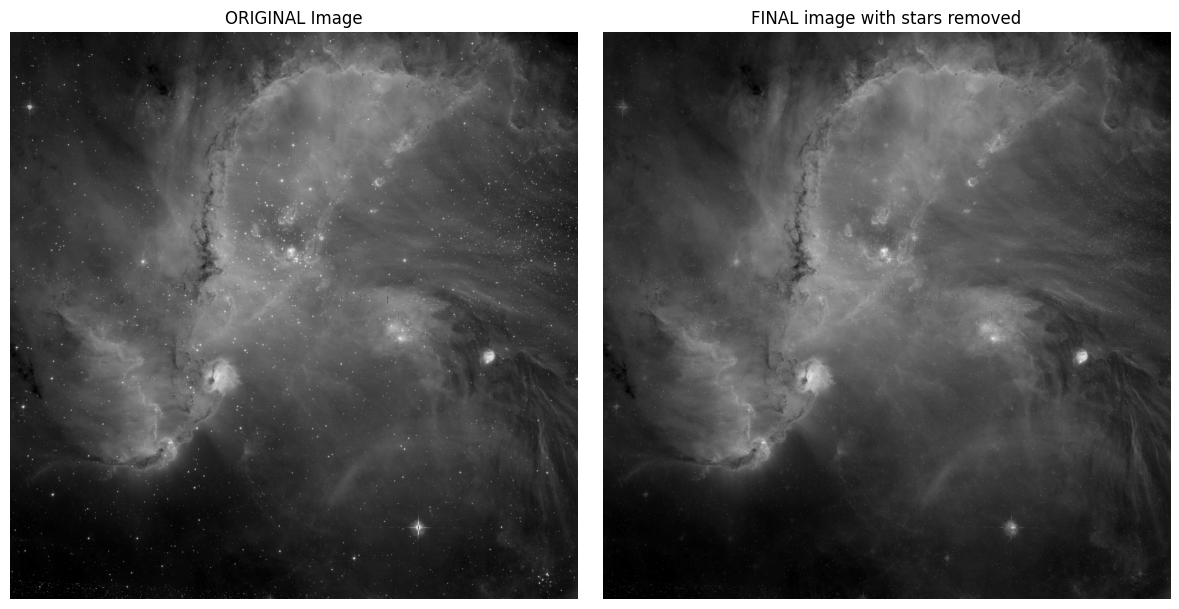

In [53]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot ORIGINAL image
axes[0].imshow(stretched_img, cmap='gray')
axes[0].set_title('ORIGINAL Image')
axes[0].axis('off')

# Plot FINAL image with stars removed
axes[1].imshow(final_image, cmap='gray')
axes[1].set_title('FINAL image with stars removed')
axes[1].axis('off')

plt.tight_layout()
plt.show()

**Per Rick**

In [15]:
final_img

array([[1.09471083e-01, 1.09259412e-01, 1.08642317e-01, ...,
        8.19939232e-05, 7.83500072e-05, 7.77719397e-05],
       [1.09538093e-01, 1.09326296e-01, 1.08707674e-01, ...,
        9.37950172e-05, 9.03043838e-05, 8.98599610e-05],
       [1.09717764e-01, 1.09507129e-01, 1.08888626e-01, ...,
        1.27341424e-04, 1.24148966e-04, 1.24029073e-04],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.70138717e-01, 1.70578241e-01, 1.70721337e-01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.70296177e-01, 1.70806482e-01, 1.70972943e-01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.70349181e-01, 1.70884788e-01, 1.71059623e-01]],
      shape=(4940, 4940), dtype=float32)

In [16]:
# import os
# import cv2

# project_root = os.getcwd()
# output_path = os.path.join(project_root, 'output', 'output_1.png')

# # make sure image is in H×W×C order for CV2 (for grayscale it's fine)
# cv2.imwrite(output_path, inpainted_img)

# print(f"Saved to {output_path}")

In [17]:
# CREATE A .fits FILE FOR FINAL BINARY MASK
# Create a primary HDU with the data
hdu = fits.PrimaryHDU(data=final_mask)
# Create a HDUList to contain the primary HDU
hdul = fits.HDUList([hdu])
# Write to file
hdul.writeto('rick/MASK_hst_skycell-p0047x09y19_acs_wfc_f658n_all_drc.fits', overwrite=True)

# CREATE A .fits FILE FOR FINAL IMAGE
# Create a primary HDU with the data
hdu = fits.PrimaryHDU(data=final_img)

# Create a HDUList to contain the primary HDU
hdul = fits.HDUList([hdu])

# Write to file
hdul.writeto('rick/OUTPUT_hst_skycell-p0047x09y19_acs_wfc_f658n_all_drc.fits', overwrite=True)